In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
#!pip install shap
import shap

In [2]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')


In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [4]:
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev)
X_test = scaler.transform(X_test)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2, stratify = y_dev, random_state = 42, )

In [6]:
y_train.value_counts()

0    228
1    136
Name: diagnosis, dtype: int64

In [7]:
y_test.value_counts()

0    72
1    42
Name: diagnosis, dtype: int64

## Primal SVMs

In [8]:
primal_svm = LinearSVC(tol=0.0001, C=1.0, dual = False)
primal_svm.fit(X_dev,y_dev)


LinearSVC(dual=False)

In [9]:
y_pred = primal_svm.predict(X_test)
print('Accuracy of the baseline primal SVM: ', accuracy_score(y_test, y_pred))
print('Precision of the baseline primal SVM: ', precision_score(y_test, y_pred))
print('Recall of the baseline primal SVM: ', recall_score(y_test, y_pred))
print('f1 of the baseline primal SVM: ', f1_score(y_test, y_pred))

Accuracy of the baseline primal SVM:  0.9649122807017544
Precision of the baseline primal SVM:  0.975
Recall of the baseline primal SVM:  0.9285714285714286
f1 of the baseline primal SVM:  0.951219512195122


In [10]:
primal_svm.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


params = {"C":np.logspace(-2,10,20), 'class_weight': [None, "balanced"]}
g_primal_svm  = GridSearchCV(LinearSVC(dual = False), params, cv=10, n_jobs=8, scoring='f1')
g_primal_svm.fit(X_dev,y_dev)

print("Best Score of the tuned primal SVM: ", g_primal_svm.best_score_)
print("Best Parameters of the tuned primal SVM", g_primal_svm.best_params_)


Best Score of the tuned primal SVM:  0.9664153359290932
Best Parameters of the tuned primal SVM {'C': 0.01, 'class_weight': 'balanced'}


## Dual SVMs 

In [12]:
dual_svm = SVC(C=1, kernel = "rbf", probability = True)
dual_svm.fit(X_train, y_train)

acc_predit_train = accuracy_score(dual_svm.predict(X_train), y_train)
acc_predit_val = accuracy_score(dual_svm.predict(X_val), y_val)
acc_predit_test = accuracy_score(dual_svm.predict(X_test), y_test)

print("Accuracy of the baseline Dual SVM on the training data: ", acc_predit_train)
print("Accuracy of the baseline Dual SVM on the validation data: ", acc_predit_val)
print("Accuracy of the baseline Dual SVM on the testing data: ", acc_predit_test)

Accuracy of the baseline Dual SVM on the training data:  0.9835164835164835
Accuracy of the baseline Dual SVM on the validation data:  0.989010989010989
Accuracy of the baseline Dual SVM on the testing data:  0.9824561403508771


In [13]:
dual_params = {"C":np.logspace(-2,10,20), 'class_weight': [None, "balanced"], "kernel":["rbf","poly"]}
g_dual_svm  = GridSearchCV(dual_svm, dual_params, cv=10, n_jobs=8, scoring='f1')
g_dual_svm.fit(X_dev,y_dev)

print("Best Score: ", g_dual_svm.best_score_)
print("Best Parameter", g_dual_svm.best_params_)

Best Score:  0.9701839826839826
Best Parameter {'C': 3.359818286283781, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [14]:
acc_g_dual_svm_train = accuracy_score(g_primal_svm.predict(X_train), y_train)
acc_g_dual_svm_val = accuracy_score(g_primal_svm.predict(X_val), y_val)
acc_g_dual_svm_test = accuracy_score(g_primal_svm.predict(X_test), y_test)

print("Accuracy of the tuned Dual SVM on the traning data: ", acc_g_dual_svm_train)
print("Accuracy of the tuned Dual SVM on the validation data: ", acc_g_dual_svm_val)
print("Accuracy of the tuned Dual SVM on the testing data: ", acc_g_dual_svm_test)

Accuracy of the tuned Dual SVM on the traning data:  0.9835164835164835
Accuracy of the tuned Dual SVM on the validation data:  0.978021978021978
Accuracy of the tuned Dual SVM on the testing data:  0.9736842105263158


## Confusion Matrices for Primal and Dual SVMs

Confusion Matrix for the Primal SVM:


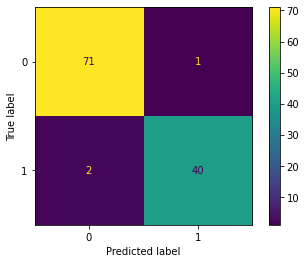

In [15]:
print("Confusion Matrix for the Primal SVM:")

primal_svm_y_pred = g_primal_svm.predict(X_test)
primal_cm = confusion_matrix(y_test, primal_svm_y_pred)
ConfusionMatrixDisplay(confusion_matrix = primal_cm).plot()
plt.show()

Confusion Matrix for the Dual SVM:


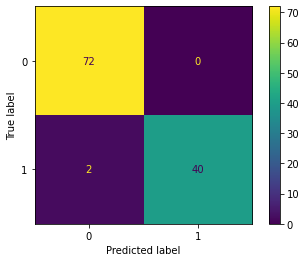

In [16]:
print("Confusion Matrix for the Dual SVM:")

dual_svm_y_pred = g_dual_svm.predict(X_test)
dual_cm = confusion_matrix(y_test, dual_svm_y_pred)
ConfusionMatrixDisplay(confusion_matrix = dual_cm).plot()
plt.show()

## SHAP Values for Primal and Dual SVMs

SHAP Plot for the tuned primal SVM



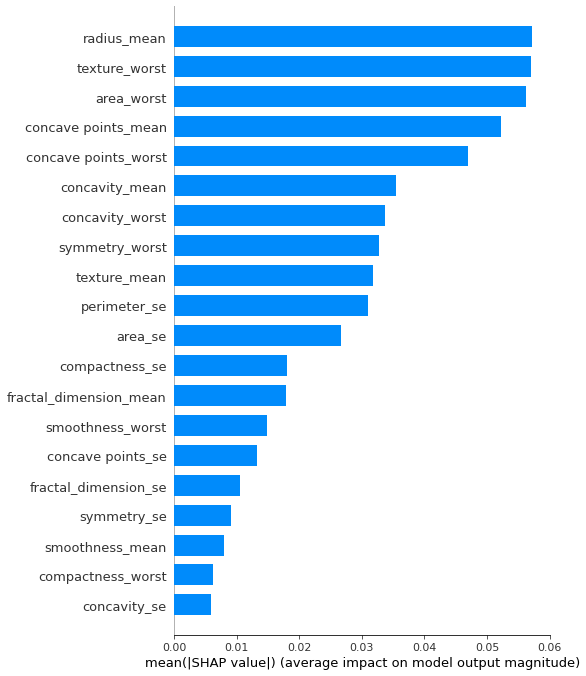

In [21]:
print("SHAP Plot for the tuned primal SVM")
print()
exp = shap.Explainer(g_primal_svm.predict, X_test)
shap.summary_plot(exp(X_test), features = X, feature_names= X.columns, plot_type='bar')

SHAP Plot for the tuned dual SVM



Permutation explainer: 115it [00:22,  5.17it/s]                         


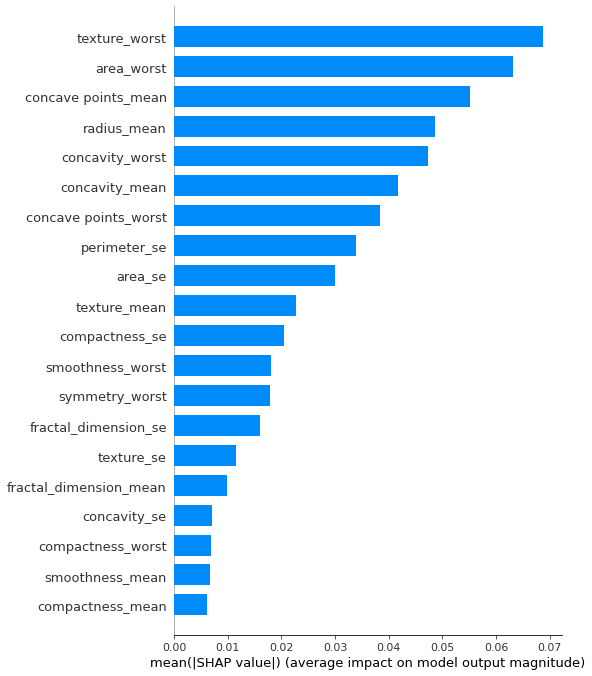

In [20]:
print("SHAP Plot for the tuned dual SVM")
print()
dual_exp = shap.Explainer(g_dual_svm.predict, X_test)
dual_shap_values = dual_exp(X_test)
shap.summary_plot(dual_shap_values, features=X, feature_names=X.columns, plot_type='bar')

## ROC Curve to compare both models

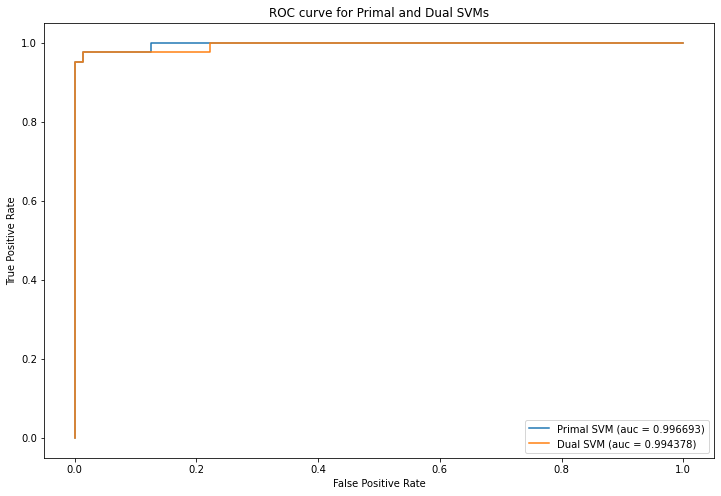

In [22]:
from sklearn.calibration import CalibratedClassifierCV

plt.figure(figsize=(12, 8))
clf = CalibratedClassifierCV(g_primal_svm) 
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='Primal SVM (auc = %0.6f)' % auc)


y_pred = g_dual_svm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='Dual SVM (auc = %0.6f)' % auc)

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for Primal and Dual SVMs")

plt.show()
     